## Data Overview

Refer to the competition page for details: https://www.kaggle.com/c/dog-breed-identification/overview

## Dependency

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Global Variables

In [2]:
# Hyperparameters
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150
validation_split=0.2

rescale=1./255
rotation_range=0
width_shift_range=0
height_shift_range=0
horizontal_flip=True
zoom_range=0

## Load Data

In [3]:
# Load file-labels data
train_dir = '../input/dog-breed-identification/train/'
df = pd.read_csv('../input/dog-breed-identification/labels.csv')
df['id']=df['id'].apply(lambda x: x+'.jpg')
class_names = np.array(sorted(df['breed'].unique()))
num_classes = class_names.shape[0]

In [4]:
# Create generator with augmentation
image_generator = ImageDataGenerator( rescale=rescale, 
                                      validation_split=validation_split,
                                      rotation_range=rotation_range,
                                      width_shift_range=width_shift_range,
                                      height_shift_range=height_shift_range,
                                      horizontal_flip=horizontal_flip,
                                      zoom_range=zoom_range)
train_data_gen = image_generator.flow_from_dataframe(dataframe=df,
                                                     subset='training',
                                                       batch_size=batch_size,
                                                       x_col='id',
                                                       y_col='breed',
                                                       directory=train_dir,
                                                       shuffle=True,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode='categorical')
validation_data_gen = image_generator.flow_from_dataframe(dataframe=df,
                                                          subset='validation',
                                                           batch_size=batch_size,
                                                           x_col='id',
                                                           y_col='breed',
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


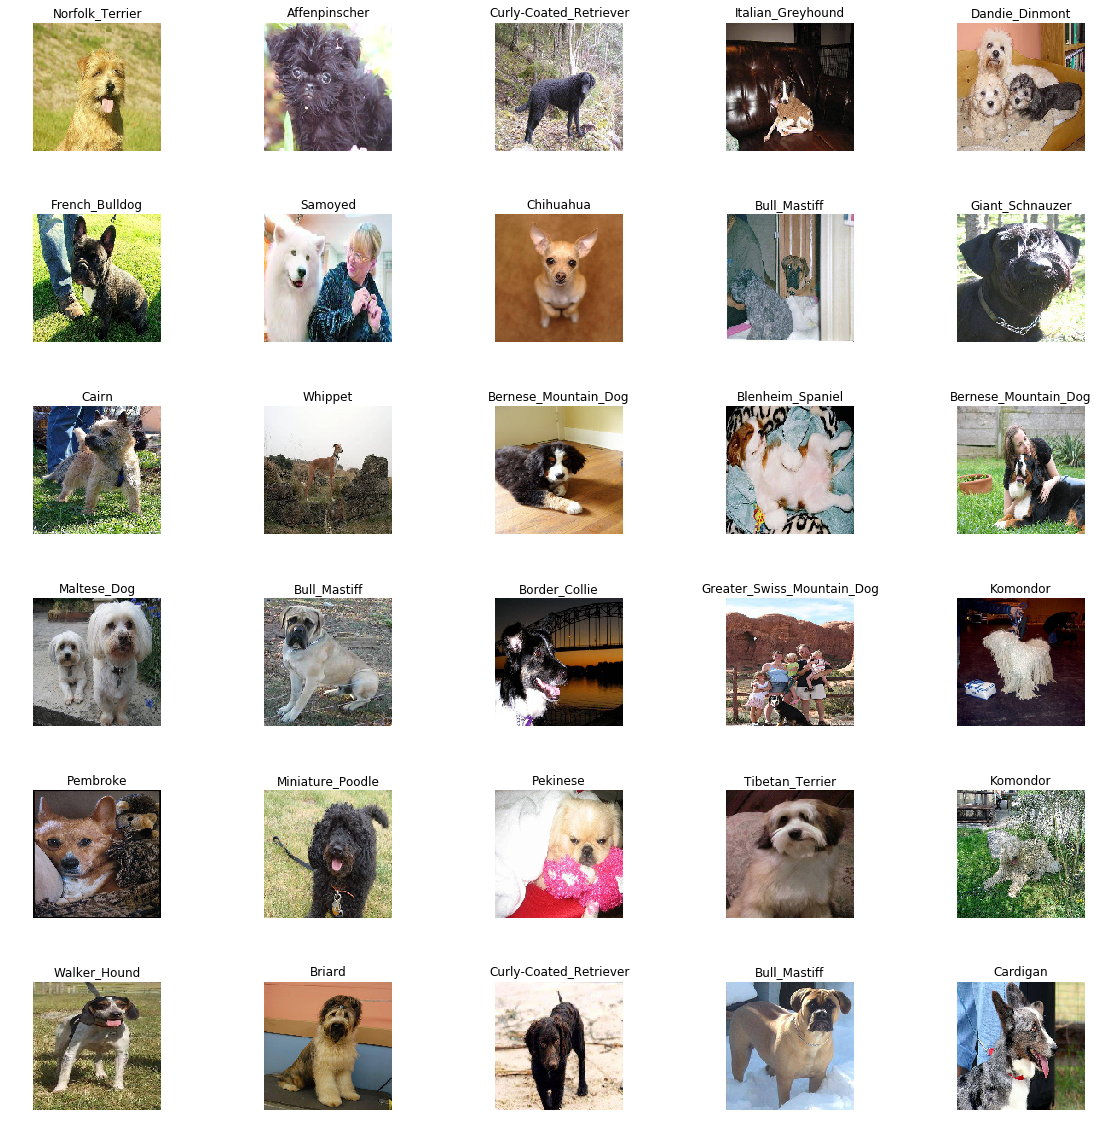

In [5]:
# Visualize sample training data
sample_training_images, sample_training_labels = next(train_data_gen)
sample_training_label_id = np.argmax(sample_training_labels, axis=-1)
sample_training_labels = class_names[sample_training_label_id]
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(sample_training_images[n])
  plt.title(sample_training_labels[n].title())
  plt.axis('off')

## Build Model

We are implementing a transfer learning by leveraging tensorflow pre-trained NN weights. The framework below can be applied to different models. An alternative is to use tf.hub (e.g. https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) 

In [6]:
# Create the base model from the pre-trained model
'''base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
                                              include_top=False,
                                             weights='imagenet')'''

base_model = tf.keras.applications.VGG16(input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the convolutional base
base_model.trainable = False

base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [7]:
# Add classification head
model = tf.keras.Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               61560     
Total params: 14,776,248
Trainable params: 61,560
Non-trainable params: 14,714,688
_________________________________________________________________


## Train Model

In [8]:
# Complile the model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [9]:
# Start training
steps_per_epoch = np.ceil(train_data_gen.samples/train_data_gen.batch_size)
validation_steps = np.ceil(validation_data_gen.samples/validation_data_gen.batch_size)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=validation_steps
)

Epoch 1/10
64/64 [==============================] - 1216s 19s/step - loss: 4.7715 - acc: 0.0192 - val_loss: 4.6599 - val_acc: 0.0328
Epoch 2/10
64/64 [==============================] - 1209s 19s/step - loss: 4.5583 - acc: 0.0566 - val_loss: 4.5329 - val_acc: 0.0494
Epoch 3/10
64/64 [==============================] - 1210s 19s/step - loss: 4.3973 - acc: 0.0931 - val_loss: 4.4170 - val_acc: 0.0753
Epoch 4/10
64/64 [==============================] - 1208s 19s/step - loss: 4.2625 - acc: 0.1289 - val_loss: 4.3250 - val_acc: 0.0895
Epoch 5/10
64/64 [==============================] - 1211s 19s/step - loss: 4.1431 - acc: 0.1497 - val_loss: 4.2422 - val_acc: 0.1023
Epoch 6/10
64/64 [==============================] - 1207s 19s/step - loss: 4.0361 - acc: 0.1736 - val_loss: 4.1635 - val_acc: 0.1169
Epoch 7/10
64/64 [==============================] - 1205s 19s/step - loss: 3.9395 - acc: 0.1844 - val_loss: 4.1006 - val_acc: 0.1223
Epoch 8/10
64/64 [==============================] - 1221s 19s/step - 

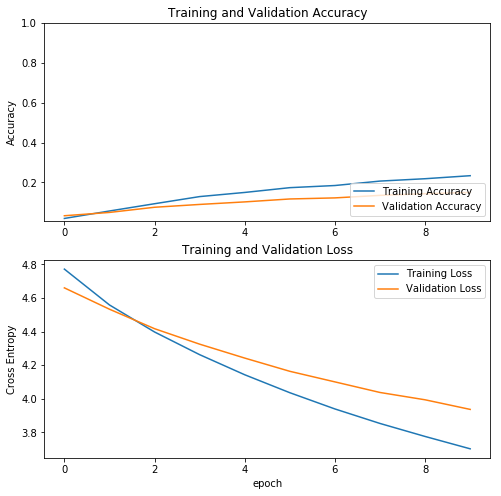

In [10]:
# Visualize the learning curve
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()